In [46]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [47]:
from fastai.vision import *
from fastai.tabular import *
from fastai.callbacks import *

import numpy as np
import pandas as pd

In [121]:
root_path = Path(r"C:\Users\William\Google Drive (william.dl.cameron@gmail.com)\Insight Project\Output_Guys")
images_path = root_path/'Images'
models_path = root_path/'Models'; root_path.mkdir(exist_ok = True)
cnn_model_name = 'Trained_Model.pkl'
dep_var = 'engagement_factor_moving_avg'  #This is the variable you are trying to predict


df = pd.read_csv(root_path/'processed_dataframe.csv')
df = df[~np.isnan(df['red'])]
for name in df.columns:
    if name.startswith('Unnamed'): df.drop(name, axis = 1, inplace = True)
        




df = df[~pd.isnull(df[dep_var])]

print (len(df))

6825


# Stage 1 - Train the Image Model (CNN)

In [122]:
#defaults.device = torch.device('cpu')
#defaults.device = torch.device('cuda')

In [123]:
#Establish the validation set based on the most recent 20% of posts
df['is_valid'] = False
for group in df.groupby('username'):
    #print(len(group[1])//5, group[1].iloc[0:10].index)
    df.loc[group[1].iloc[0:len(group[1])//5].index,'is_valid'] = True

In [95]:
data = (ImageList.from_df(df = df, path = images_path, cols = 'filename', suffix = '.jpg')
        #.filter_by_func(lambda x: print(x))
        #.split_by_rand_pct()
        .split_from_df(col = 'is_valid')
        .label_from_df(cols = dep_var)
        .transform([[],[]], size = 400)
        .databunch(bs = 32, num_workers = 0)
       )

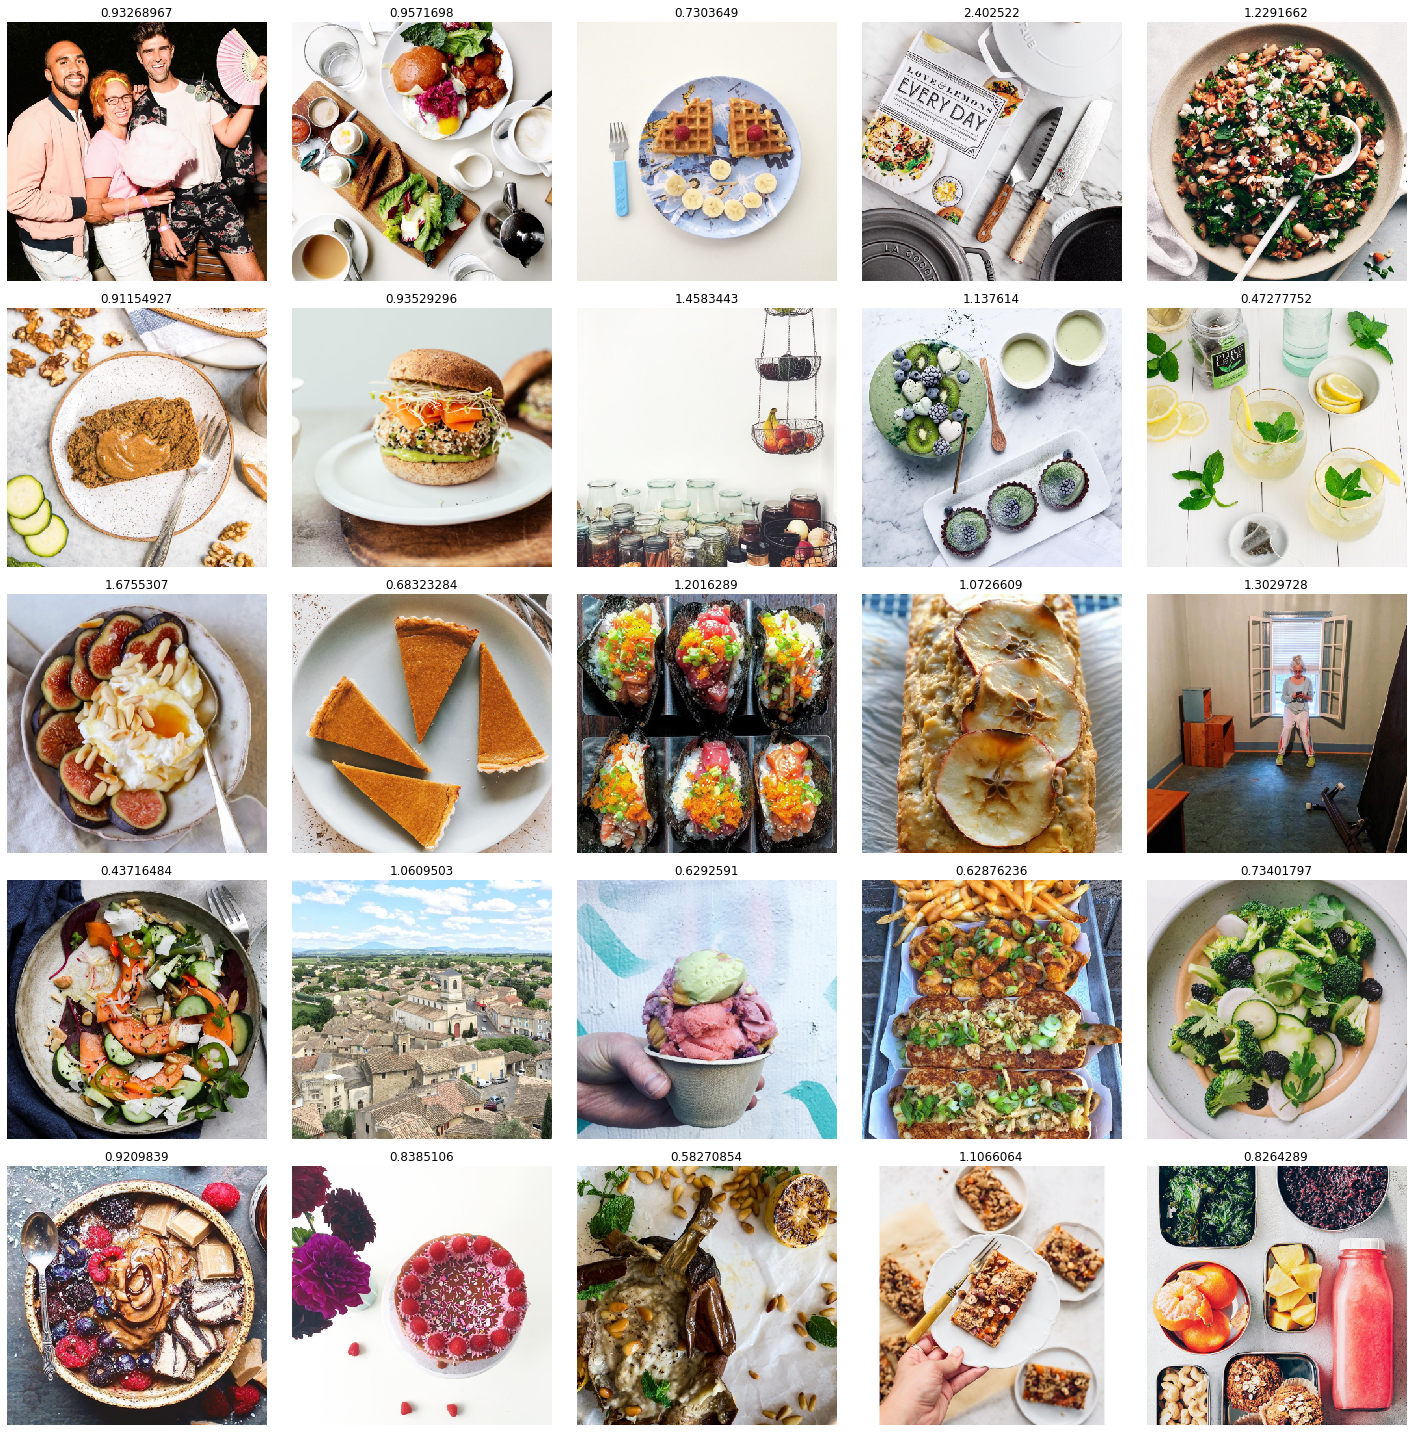

In [96]:
data.show_batch()

In [9]:
learn = cnn_learner(data, models.resnet34)

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

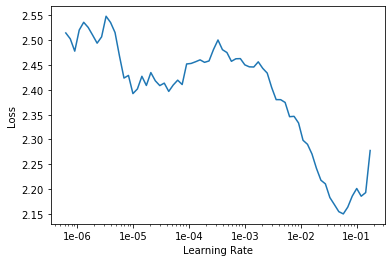

In [22]:
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(5, max_lr = 1e-2)

KeyboardInterrupt: 

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


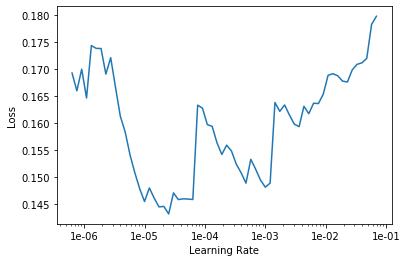

In [26]:
# learn.lr_find()
# learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(20, 1e-2/10)

In [29]:
learn.export(models_path/cnn_model_name)

In [45]:
learn.show_results()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [30]:
interp = learn.interpret()

In [44]:
learn = load_learner(models_path, cnn_model_name, num_workers = 0)

# Stage 2 - Gather Predictions for the Tabular Model

In [7]:
test_data = (ImageList.from_df(df, images_path, suffix = '.jpg', cols = 'filename')
             .filter_by_func(lambda x: (images_path/x).exists()))
learn = load_learner(models_path, cnn_model_name, test = test_data)
preds = learn.get_preds(ds_type = DatasetType.Test)
df['cnn_prediction'] = [x.item() for x in preds[0]]
df.to_csv(root_path/'final_with_cnn_predictions.csv') 

# Stage 3 - Tabular Model

In [124]:
"""Option 1 """
df = pd.read_csv(root_path/'final_with_cnn_predictions.csv')


In [125]:
df['is_valid'] = False
for group in df.groupby('username'):
    #print(len(group[1])//5, group[1].iloc[0:10].index)
    df.loc[group[1].iloc[0:len(group[1])//5].index,'is_valid'] = True

In [9]:
tab_model_name = 'Tabular Model Basic Parameters.pkl'


cat_names = ['year', 
             'day_name', 
             'month',
             'username']
cont_names = ['followers', 
              'following', 
              'num_posts', 
              'rolling_avg', 
              'hour',
              'brightness',
              'contrast',
             ]
procs = [FillMissing, Categorify]#, Normalize]

In [10]:
tab_model_name = 'All Features.pkl'
prediction_type = 'all_in__prediction'

cat_names = ['year', 
             'day_name', 
             'month',
             'username']
cont_names = ['engagement_factor_std',
              'Engagement (Avg Likes)',
              'followers',
              'following',
              'hour', 'date', 'minute', 'second',
              'rel_brightness_moving_avg',
              'rel_contrast_moving_avg',
              'red', 'green',
               'blue', 'brightness', 'red_range', 'green_range', 'blue_range',
               'contrast',
             ]



procs = [FillMissing, Categorify, Normalize]

In [126]:
tab_model_name = 'Tabular Model No CNN.pkl'
prediction_type = 'tab_only_prediction'

cat_names = ['year', 
             'day_name', 
             'month',
             'username']
cont_names = ['engagement_factor_std',
              'hour',
              'rel_brightness_moving_avg',
              'rel_contrast_moving_avg',
             ]
procs = [FillMissing, Categorify, Normalize]

In [141]:
tab_model_name = 'Tabular Model Engineered Parameters.pkl'
prediction_type = 'tab_prediction'

cat_names = ['year', 
             'day_name', 
             'month',
             'username']
cont_names = ['cnn_prediction',
              'engagement_factor_std',
              'hour',
              'rel_brightness_moving_avg',
              'rel_contrast_moving_avg',
             ]
procs = [FillMissing, Categorify, Normalize]

In [12]:
df.columns

Index(['Unnamed: 0', 'Downloaded', 'Engagement (Avg Likes)', 'Links',
       'alt-text', 'caption', 'followers', 'following', 'likes', 'num_posts',
       'posttime', 'tags', 'username', 'filename',
       'engagement_factor_avg_likes', 'rolling_avg',
       'engagement_factor_moving_avg', 'date', 'hour', 'minute', 'second',
       'month', 'year', 'day_name', 'performance', 'red', 'green', 'blue',
       'brightness', 'red_range', 'green_range', 'blue_range', 'contrast',
       'prediction', 'rolling', 'engagement_factor_std',
       'rel_contrast_moving_avg', 'rel_brightness_moving_avg',
       'cnn_prediction'],
      dtype='object')

In [142]:
data = (TabularList.from_df(df, path = root_path, cat_names = cat_names, cont_names = cont_names, procs = procs)
        #.split_by_rand_pct()
        .split_from_df(col = 'is_valid')
        .label_from_df(cols = dep_var)
        .databunch(num_workers = 0)
       )

In [143]:
tab_learn = tabular_learner(data, layers = [20,10])#, metrics=[accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


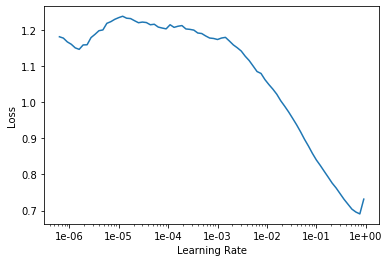

In [144]:
tab_learn.lr_find()
tab_learn.recorder.plot()

In [145]:
tab_learn.fit_one_cycle(10, max_lr = 1e-2)

In [146]:
tab_learn.export(models_path/tab_model_name)

In [147]:
tab_learn.show_results(10)

# Step 4 - Tabular Model Predictions

In [148]:
test_data = TabularList.from_df(df, path = root_path, cat_names = cat_names, cont_names = cont_names, procs = procs)
tab_learn = load_learner(models_path, tab_model_name, test = test_data)
preds = tab_learn.get_preds(DatasetType.Test)
df[prediction_type] = [x.item() for x in preds[0]]
df.to_csv(root_path/'final_with_cnn_and_tab_predictions.csv')

In [149]:
cat_names

['year',
 'day_name',
 'month',
 'username',
 'engagement_factor_std_na',
 'rel_brightness_moving_avg_na',
 'rel_contrast_moving_avg_na']

In [35]:
test_data = TabularList.from_df(df, path = root_path, cat_names = cat_names, cont_names = cont_names, procs = procs)
tab_learn = load_learner(models_path, tab_model_name, test = test_data)
preds = tab_learn.get_preds(DatasetType.Test)
preds = [x.item() for x in preds[0]]

In [36]:
preds

[0.7823899388313293,
 1.4704997539520264,
 1.2201199531555176,
 0.9130629897117615,
 0.9231959581375122,
 1.1101996898651123,
 1.4535683393478394,
 0.8496862649917603,
 1.1147241592407227,
 0.9824466705322266,
 1.183847188949585,
 0.847145140171051,
 1.0924065113067627,
 1.1165900230407715,
 1.1220043897628784,
 0.9463614225387573,
 1.0946924686431885,
 0.8531251549720764,
 1.2825592756271362,
 1.0270262956619263,
 1.0847774744033813,
 1.1637868881225586,
 0.6645638346672058,
 0.8380498886108398,
 0.8895225524902344,
 1.1157200336456299,
 1.0381648540496826,
 1.1008830070495605,
 0.8809553980827332,
 0.9618333578109741,
 1.0187458992004395,
 0.9892532229423523,
 0.6017481088638306,
 1.1653084754943848,
 0.7298051714897156,
 0.7805230021476746,
 0.9923564195632935,
 0.9841204881668091,
 0.9126601219177246,
 1.2202228307724,
 1.0557663440704346,
 1.2179511785507202,
 1.0400373935699463,
 0.9657493829727173,
 1.077451467514038,
 1.0554805994033813,
 0.7652981877326965,
 0.963506817817688,

# Playground - Investigating other functions

In [150]:
def get_stats(series):
    return series.mean(), series.std()

def normalize(series, mean, std):
    m, s = get_stats(series)
    new_series = np.add(np.multiply(np.subtract(series,m),(std/s)), mean)
    return new_series

def save_seaborn_plot(f, filepath):
    ax = f.get_figure()
    ax.tight_layout()
    ax.savefig(filepath, dpi = 600)



In [151]:
def get_MSE(randomized_var, df, cont = True):
    cat_names_temp, cont_names_temp = cat_names.copy(), cont_names.copy()
    new_df = df.copy(deep = True)
    new_df = new_df[new_df['is_valid'] == True]
    #df = pd.read_csv(root_path/'final_with_cnn_predictions.csv')
    
    
    if cont:
        new_df['random_temp'] = np.random.normal(size = len(new_df))
        new_df[randomized_var] = normalize(new_df['random_temp'],*get_stats(df[randomized_var]))
        #cat_names_temp, cont_names_temp = cat_names.copy(), cont_names.copy()
        #cont_names_temp = ['random_temp' if x==randomized_var else x for x in cont_names_temp]
        #cat_names_temp = ['random_temp' if x==randomized_var else x for x in cat_names_temp]
    else:
        new_df[randomized_var] = np.random.permutation(new_df[randomized_var])
    
    test_data = TabularList.from_df(new_df, path = root_path, cat_names = cat_names_temp, cont_names = cont_names_temp, procs = procs)
    tab_learn = load_learner(models_path, tab_model_name, test = test_data)
    preds = tab_learn.get_preds(DatasetType.Test)
    preds = [x.item() for x in preds[0]]
    MSE = np.power(new_df[dep_var]-preds, 2).mean()
    print(randomized_var, MSE)
    return MSE

In [152]:
get_MSE('cnn_prediction', df)

cnn_prediction 0.2499816703553252


0.2499816703553252

In [153]:
MSE_array = []
MSE_names = []

MSE_array.append(get_MSE('likes', df, cont=True))
MSE_names.append('Baseline')

for cont_var in cont_names:
    MSE_array.append(get_MSE(cont_var, df, cont=True))
    MSE_names.append(cont_var)
for cat_var in cat_names:
    MSE_array.append(get_MSE(cat_var, df, cont=False))
    MSE_names.append(cat_var)

likes 0.12283171313039008


cnn_prediction 0.2535438607836134


engagement_factor_std 0.13789766524494035


hour 0.12514438337836234


rel_brightness_moving_avg 0.12524867843994794


rel_contrast_moving_avg 0.12252743390842806


year 0.1292263942398869


day_name 0.1238194122467344


month 0.12313869329091622


username 0.13103919817499865


KeyError: 'engagement_factor_std_na'

In [169]:
import seaborn as sns
sns.set_context('paper')
sns.set_style("white")

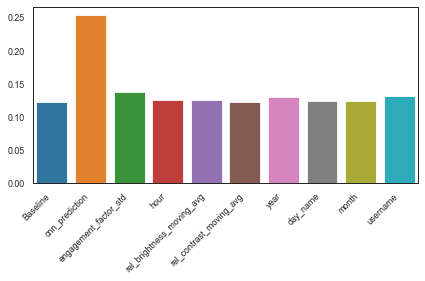

In [170]:
g = sns.barplot(MSE_names, MSE_array)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
save_seaborn_plot(g, root_path/'Figures'/'feature_importance.png')

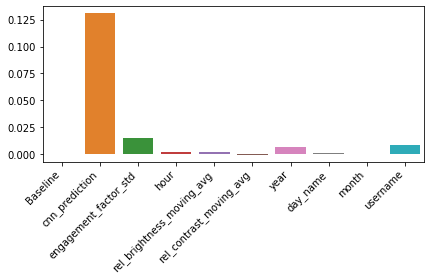

In [156]:
g = sns.barplot(MSE_names, [x-MSE_array[0] for x in MSE_array])
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
save_seaborn_plot(g, root_path/'Figures'/'feature_importance-relative.png')

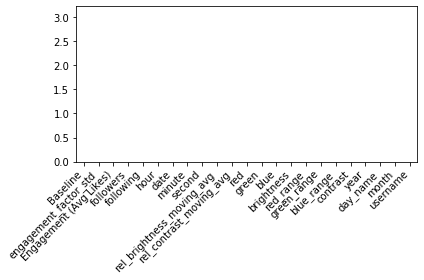

In [99]:
g = sns.barplot(MSE_names, MSE_array)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
save_seaborn_plot(g, root_path/'Figures'/'feature_importance_all_in.png')

In [100]:
MSE_array

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [ ]:
result_counter = {'Normal': 0, 'Low':0, 'High':0}
for i, _ in df.iterrows():
    pred = learn.predict(df.iloc[i])[0].obj
    result_counter[pred] += 1
print (f"High: {result_counter['High']}, Med: {result_counter['Normal']}, Low: {result_counter['Low']}")

In [8]:
df['filename'] = [url.split(r'/')[-2] for url in df['Links']]

In [9]:
df.head()

Downloaded  Engagement (Avg Likes)  \
10         1.0                     NaN   
11         1.0                     NaN   
12         1.0                     NaN   
13         1.0                     NaN   
14         1.0                     NaN   

                                       Links  \
10  https://www.instagram.com/p/B6rIiJMBNuK/   
11  https://www.instagram.com/p/BuR4MIuB_1i/   
12  https://www.instagram.com/p/BgMKji2DXPe/   
13  https://www.instagram.com/p/Bc_EitTjWl5/   
14  https://www.instagram.com/p/BTWasLfDfN4/   

                                             alt-text  \
10                            Image may contain: food   
11                            Image may contain: food   
12           Photo by Ashley Marti on March 11, 2018.   
13  Photo shared by Ashley Marti on December 21, 2...   
14  Photo by Ashley Marti in Elder Hall with @will...   

                                              caption  followers  following  \
10  Yogurt dips always and forever. Labne with Siz...     129270       1341   
11  Made @basically Chicken and Rice Soup with Gar...     129270       1341   
12                 golden beet hummus with sesame oil     129270       1341   
13  Taking a break from all of the holiday cookies...     129270       1341   
14  PORTLAND #giveaway! Enter to win a seat at the...     129270       1341   

     likes  num_posts                  posttime  ... day_name performance  \
10  3003.0       2584  2019-12-29T22:59:01.000Z  ...      7.0        High   
11  4223.0       2584  2019-02-24T21:18:27.000Z  ...      7.0        High   
12  1610.0       2584  2018-03-11T16:43:59.000Z  ...      7.0        High   
13  1191.0       2584  2017-12-22T01:07:08.000Z  ...      5.0         Low   
14  1525.0       2584  2017-04-26T13:29:15.000Z  ...      3.0      Normal   

           red       green        blue  brightness  red_range  green_range  \
10  165.758434  155.697325  147.319075  156.258278      224.0        226.0   
11  195.326505  187.656672  172.342082  185.108420      202.0        185.0   
12  189.139726  170.260187  142.274926  167.224946      152.0        180.0   
13  178.292824  170.629448  159.441829  169.454700      201.0        212.0   
14  176.551989  171.092073  160.501949  169.382004      209.0        212.0   

    blue_range  contrast  
10       236.0     232.0  
11       235.0     214.0  
12       213.0     194.0  
13       224.0     215.0  
14       219.0     214.0  

[5 rows x 32 columns]

# Combined Model

In [11]:
tabularData = TabularList.from_df(df, path = path, cat_names = cat_names, cont_names = cont_names, procs = procs)
imageData = ImageList.from_df(df = df, path = path, cols = 'filename', suffix = '.jpg')

In [55]:
sdf = df.sort_values(['username', 'posttime'], ascending=False)

In [90]:
sdf['is_valid'] = False
for group in sdf.groupby('username'):
    print(len(group[1])//5, group[1].iloc[0:10].index)
    sdf.loc[group[1].iloc[0:len(group[1])//5].index,'is_valid'] = True

2 Int64Index([7122, 7131, 7130, 7124, 7123, 7133, 7125, 7127, 7132, 7128], dtype='int64')
4 Int64Index([12090, 12103, 12100, 12097, 12101, 12095, 12102, 12104, 12084,
            12092],
           dtype='int64')
2 Int64Index([12029, 12026, 12032, 12024, 12034, 12030, 12025, 12033, 12027,
            12035],
           dtype='int64')
2 Int64Index([12160, 12156, 12165, 12161, 12155, 12164, 12157, 12162, 12154,
            12158],
           dtype='int64')
2 Int64Index([12135, 12137, 12136, 12130, 12132, 12141, 12138, 12133, 12131,
            12140],
           dtype='int64')
2 Int64Index([12057, 12049, 12052, 12050, 12058, 12053, 12054, 12051, 12059,
            12056],
           dtype='int64')
21 Int64Index([3798, 3765, 3745, 3737, 3770, 3742, 3711, 3719, 3759, 3763], dtype='int64')
2 Int64Index([4793, 4791, 4790, 4796, 4797, 4800, 4794, 4792, 4798, 4795], dtype='int64')
2 Int64Index([12003, 12009, 12005, 12007, 12006, 12010, 12011, 12012, 12002,
            12004],
           dtype=

In [91]:
sdf.to_csv('test2.csv')

In [ ]:
"""class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cnn = models.inception_v3(pretrained=False, aux_logits=False)
        self.cnn.fc = nn.Linear(
            self.cnn.fc.in_features, 20)
        
        self.fc1 = nn.Linear(20 + 10, 60)
        self.fc2 = nn.Linear(60, 5)
        
    def forward(self, image, data):
        x1 = self.cnn(image)
        x2 = data
        
        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

model = MyModel()

batch_size = 2
image = torch.randn(batch_size, 3, 299, 299)
data = torch.randn(batch_size, 10)

output = model(image, data)"""